### CODE MUST BE RUN ON DISCOVERY BC OF PYTHON VERSIONS

### This code takes the parcellated outputs from the GLM and computes the pattern distance between episodes (reevaluated and control) between Listens (per individual)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import tqdm
from matplotlib.pyplot import savefig 

def save_function(fname):
    savefig(fname, dpi=500, format=None, metadata=None,
            bbox_inches=None, 
            transparent=True, edgecolor='auto',
            backend=None)
    return None



In [2]:
def calculate_correlation(A, B):
    ## Create a mask where both A and B are not NaN
    mask = ~np.isnan(A) & ~np.isnan(B)

    A_masked = A[mask]
    B_masked = B[mask]
    
    correlation, _ = pearsonr(A_masked, B_masked)
    
    return correlation

In [3]:
sub_nums = list(range(1, 38))
idx = sub_nums.index(18) #there is no data for subject 18!
sub_nums.pop(idx)
sub_nums = [f'sub-{val:02}' for val in sub_nums]  

data_dir = 'glm_out'
data_dir_local = '../../../darkend/data/'

In [8]:
### Event length:

# #reorganized by how they were put into the AFNI Timing GLM script 
onsets = [22, 70, 144, 171, 235, 261, 303, 366, 420, 470]
offsets = [30, 78, 153, 180, 246, 272, 321, 384, 447, 497]

label = ['reappraisal','control','control','reappraisal','control', 'reappraisal', 'reappraisal', 'control', 'control', 'reappraisal']
name = ['conversation_bf', 'welcome_store_control', 'store_knowledge_control', 'calls_robot', 'dress_against_policy_control', 'steve_skinny', 'emergency_song', 'excuse_me_control', 'lucy_nice_control', 'resolution']
event_num = range(1,11)


df = pd.DataFrame()
df['onsets'] = onsets
df['offsets'] = offsets
df['len'] = df['offsets']- df['onsets']
df['label'] = label 
df['name'] = name
df['event_num'] = event_num

df

,onsets,offsets,len,label,name,event_num
0,22,30,8,reappraisal,conversation_bf,1
1,70,78,8,control,welcome_store_control,2
2,144,153,9,control,store_knowledge_control,3
3,171,180,9,reappraisal,calls_robot,4
4,235,246,11,control,dress_against_policy_control,5
5,261,272,11,reappraisal,steve_skinny,6
6,303,321,18,reappraisal,emergency_song,7
7,366,384,18,control,excuse_me_control,8
8,420,447,27,control,lucy_nice_control,9
9,470,497,27,reappraisal,resolution,10


#### Computing the r-value in each node for episode type (reevaluated versus control) that will then be put into LME model

In [ ]:
sub_list = []
node_list = []
episode_list = []
r_list = [] #actually going to be Fisher z-transformed
episode_label = []


for sub in tqdm.tqdm(sub_nums):


    listen = 'L1'
    data_L1 = np.load(data_dir_local + '_schaeffer_rois_reevaluated_null/' + f'{sub}_7N_reevaluated_periods_{listen}_subcortical_included.npy',allow_pickle=True).item()

    listen = 'L2'
    data_L2 = np.load(data_dir_local + '_schaeffer_rois_reevaluated_null/' + f'{sub}_7N_reevaluated_periods_{listen}_subcortical_included.npy',allow_pickle=True).item()

    for node in list(data_L1.keys()):
        
        for episode in df['event_num']:
            
            sub_list.append(sub)
            node_list.append(node)
            episode_list.append(episode)
            episode_label.append(list(df[df['event_num']==episode]['label'])[0])

            r_list.append(np.arctanh(calculate_correlation(data_L1[node][episode],data_L2[node][episode])))
              
        
r_vals_for_GLM = pd.DataFrame()
r_vals_for_GLM['sub'] = sub_list
r_vals_for_GLM['node'] = node_list
r_vals_for_GLM['episode'] = episode_list
r_vals_for_GLM['label'] = episode_label
r_vals_for_GLM['r'] = r_list

r_vals_for_GLM
    
    
    
    
    

In [14]:
r_vals_for_GLM.to_csv('2.2._rvals_per_reevaluated_episode_include_subcortical.csv')


### Plotting the inset

In [27]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
                        
def chunkwise(t, size=2):
    it = iter(t)
    return zip(*[it]*size)
def scatter_boxplot(boxplot_kwargs,face_pal,df, x, y):

    fig, ax = plt.subplots(dpi=400)

    sns.boxplot(x=x, y=y,  data=df, saturation=1, showfliers=False,palette=face_pal,
             **boxplot_kwargs, ax=ax, zorder=10)

    sns.stripplot(x=x, y=y,  data=df,size=8,
                  marker='o', color='0.6', alpha=1, edgecolor='k', linewidth=0.5, dodge=True, palette=face_pal_lighter, ax=ax)
    
    #ax.get_legend().remove()
    
    for ax1, ax2 in chunkwise(ax.collections, size=2):
        for (x0, y0), (x1, y1) in zip(ax1.get_offsets(), ax2.get_offsets()):
            ax.plot([x0, x1], [y0, y1], color='black', alpha=0.3, linewidth=0.5)
    
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[:2], labels[:2])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax


In [21]:

# Prepare the data
events = df['event_num'].unique()
data_list = []

sub = sub_nums[12]
node = 39 #38

for sub in sub_nums:
    for event in events:
        # Load data for Listen 1 (L1)
        listen = 'L1'
        data_L1 = np.load(data_dir_local + '_schaeffer_rois_reappraisal_null_3shorter_events/' + f'{sub}_7N_reappraisal_periods_{listen}.npy', allow_pickle=True).item()

        # Load data for Listen 2 (L2)
        listen = 'L2'
        data_L2 = np.load(data_dir_local + '_schaeffer_rois_reappraisal_null_3shorter_events/' + f'{sub}_7N_reappraisal_periods_{listen}.npy', allow_pickle=True).item()

        # Calculate the value (1 - correlation)
        value = 1 - np.arctanh(calculate_correlation(data_L1[node][event], data_L2[node][event]))

        # Get the label for the event
        label = list(df[df['event_num'] == event]['label'])[0]
        pair_label = f'Pair {(event + 1) // 2}'  # Assuming pairs are consecutive events

        # Append data for this subject/event
        data_list.append({'Subject': sub, 'Pair': pair_label, 'Condition': label, 'Event': event, 'Value': value})

# Convert the list of dictionaries to a DataFrame
plot_df = pd.DataFrame(data_list)

# Now group by 'Subject', 'Condition', and 'Event' to calculate the median values
df_medians = plot_df.groupby(['Subject', 'Condition', 'Event', 'Pair'])['Value'].median().reset_index()





In [42]:

boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}


face_pal = {
    "1_reappraisal": "#ffce07",
    "2_control": "#658CC81A"
}

face_pal_lighter = {
    "1_reappraisal": "#ffeea6",
    "2_control": "#a4c4ea"
}

hue_order = ['1_reappraisal', '2_control']

boxplot_kwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                  'whiskerprops': lineprops, 'capprops': lineprops,
                  'width': 0.75, 
                  'hue_order': hue_order}

#fig = plt.figure(dpi=400)
long_df = df_medians.groupby(['Subject', 'Condition'])['Value'].median().reset_index()


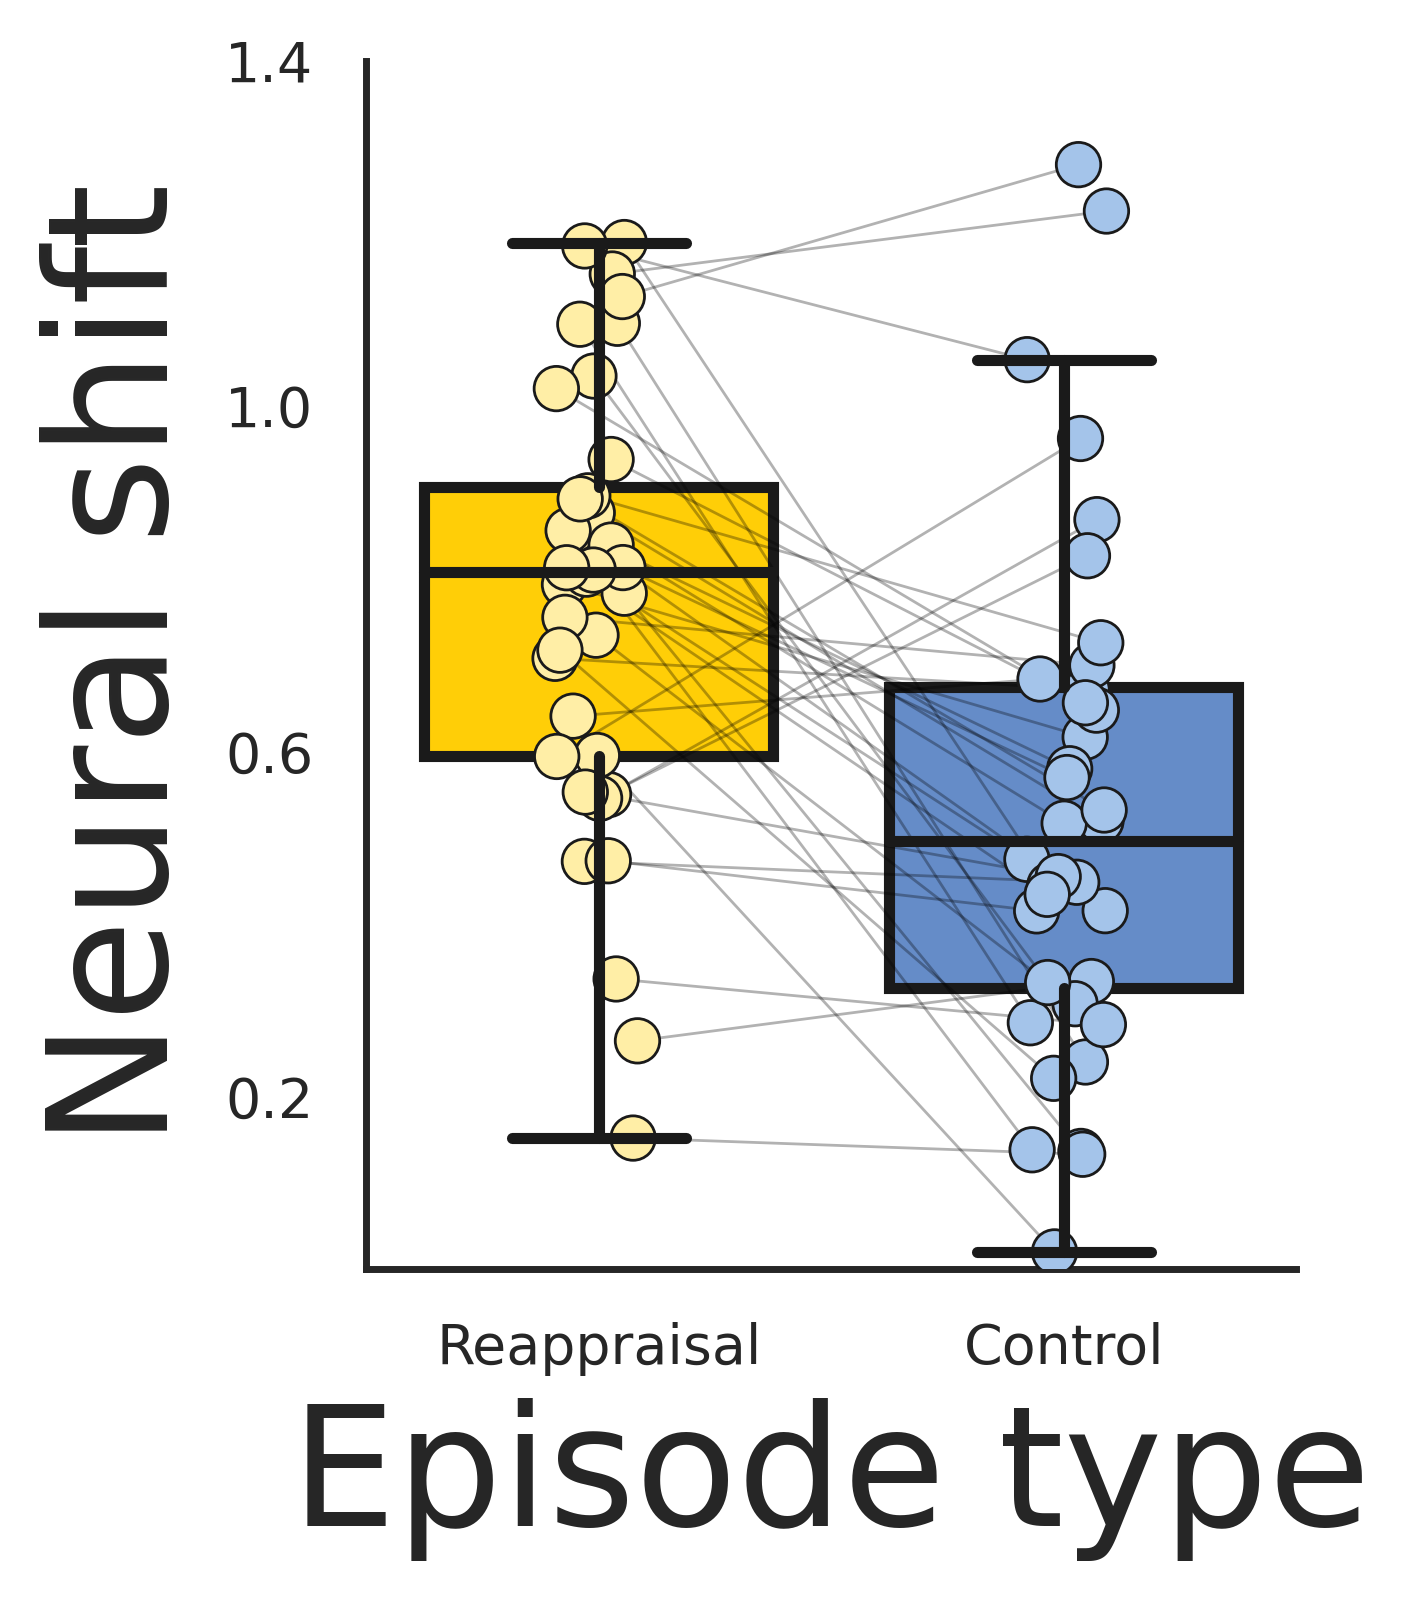

In [43]:
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize':(3,4)})
sns.set_theme(style='white')


# Rename for clarity but enforce desired order
long_df['Condition'] = long_df['Condition'].replace({
    'reappraisal': '1_reappraisal',
    'control': '2_control'
})

# Set the order explicitly
long_df['Condition'] = pd.Categorical(
    long_df['Condition'],
    categories=['1_reappraisal', '2_control'],  # Specify desired order
    ordered=True
)

# Plot as usual
scatter_boxplot(boxplot_kwargs, face_pal, long_df, x='Condition', y='Value')

# Adjust x-axis labels back to the original names
plt.xticks(ticks=plt.xticks()[0], labels=['Reappraisal', 'Control'], size=20)
ylabels = plt.yticks()[1]  # Labels
yticks = plt.yticks()[0]  # Positions of current ticks

plt.yticks(ticks=yticks[::2], size=20) 
plt.ylabel('Neural shift',size=30)
plt.xlabel('Episode type',size=30)
plt.xticks(size=10)
plt.yticks(size=10)
plt.ylim(0,1.4)

# save_function('../../../darkend/plots/02._reappraisal_segments/boxplot_comparing_reappraised_null.png')
# save_function('../../../darkend/plots/02._reappraisal_segments/boxplot_comparing_reappraised_null.svg')
plt.show()
